In this tutorial, we will introduce the following content: <br>
1. Prepare demo data<br>
2. Prepare the settings<br>
3. Train and test model<br>
4. Export onnx<br>

If you want to inference pretrained model only, you can refer to <br>
 Inference PreTrained.ipynb <br>

# Install
We have Detectron2 installed for you when you see this page

# Start trying
Ensure you have selected the right kernel (on the top right corner of jupyter lab interface), the one you have just named <br>
now we change the directory to the installed location

In [1]:
%cd detectron2

/home/z890/Downloads/ml_develop_sample/carasml/detection/d2_FasterRCNN/detectron2


/home/z890/.conda/envs/faster_d2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Prepare a demo dataset
We use a subset (tortoise and lizard) of OpenImagesV7 as demo <br>
This tutorial we aim at demonstrating how to start with a dataset with labeled with LabelImg, so we have converted the dataset to the annotation format when installing<br>
If you have not label a dataset yet, you can use LabelImg to label. Please choose PascalVOC format.
The dataset should be in below format

If your dataset is labeled by LabelImg, you can run the below script to convert it to required format 

In [2]:
# write a function that loads the dataset into detectron2's standard format
# if your dataset is not in the same format, you need to revise the code of this part
import os
import cv2
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import xml.etree.ElementTree as ET

classes_names=["Tortoise", "Lizard"]

def get_dataset_dicts(path):
    """
    Load dataset from folder containing images and XML annotations.
    
    Args:
        path (str): Path to folder containing images and XML files
        
    Returns:
        list: List of dataset dictionaries in Detectron2 format
    """
    dataset_dicts = []
    
    # Get all image files
    image_extensions = {'.jpg'} #, '.jpeg', '.png', '.bmp', '.tiff', '.tif'
    image_files = [f for f in os.listdir(path) 
                   if os.path.splitext(f.lower())[1] in image_extensions]
    
    for idx, image_file in enumerate(image_files):
        # Get corresponding XML file
        image_name = os.path.splitext(image_file)[0]
        xml_file = image_name + '.xml'
        xml_path = os.path.join(path, xml_file)
        image_path = os.path.join(path, image_file)
        
        # Skip if XML doesn't exist
        if not os.path.exists(xml_path):
            print(f"Warning: No XML annotation found for {image_file}")
            continue
            
        # Read image to get dimensions
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_file}")
            continue
            
        height, width = img.shape[:2]
        
        # Parse XML annotation
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Extract image info from XML (optional, using CV2 info as primary)
            size_elem = root.find('size')
            if size_elem is not None:
                xml_width = int(size_elem.find('width').text)
                xml_height = int(size_elem.find('height').text)
                # Use XML dimensions if they differ from image
                if xml_width != width or xml_height != height:
                    print(f"Dimension mismatch for {image_file}: "
                          f"Image({width}x{height}) vs XML({xml_width}x{xml_height})")
                    # Use image dimensions as they're more reliable
            
            # Create record for this image
            record = {
                "file_name": image_path,
                "image_id": idx,
                "height": height,
                "width": width,
                "annotations": []
            }
            
            # Extract all objects/annotations
            for obj in root.findall('object'):
                # Get class name
                name_elem = obj.find('name')
                if name_elem is None:
                    continue
                category_name = name_elem.text
                
                # Get bounding box
                bndbox = obj.find('bndbox')
                if bndbox is None:
                    continue
                    
                try:
                    xmin = float(bndbox.find('xmin').text)
                    ymin = float(bndbox.find('ymin').text)
                    xmax = float(bndbox.find('xmax').text)
                    ymax = float(bndbox.find('ymax').text)
                    
                    # Ensure coordinates are within image bounds
                    xmin = max(0, min(xmin, width - 1))
                    ymin = max(0, min(ymin, height - 1))
                    xmax = max(xmin + 1, min(xmax, width))
                    ymax = max(ymin + 1, min(ymax, height))
                    
                    # Create annotation
                    annotation = {
                        "bbox": [xmin, ymin, xmax, ymax],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": classes_names.index(category_name),  # You'll need to implement this
                        "category_name": category_name
                    }
                    
                    record["annotations"].append(annotation)
                    
                except (ValueError, AttributeError) as e:
                    print(f"Error parsing bounding box in {xml_file}: {e}")
                    continue
            
            dataset_dicts.append(record)
            
        except ET.ParseError as e:
            print(f"Error parsing XML file {xml_file}: {e}")
            continue
    
    return dataset_dicts

In [3]:
# register the dataset
for d in ["train","validation"]: 
    DatasetCatalog.register("turnliz_" + d, lambda d=d: get_dataset_dicts("dataset/open-images-v7/"+ d+"/"))
    MetadataCatalog.get("turnliz_" + d).set(thing_classes=classes_names,evaluator_type="coco")
turnliz_metadata = MetadataCatalog.get("turnliz_train")

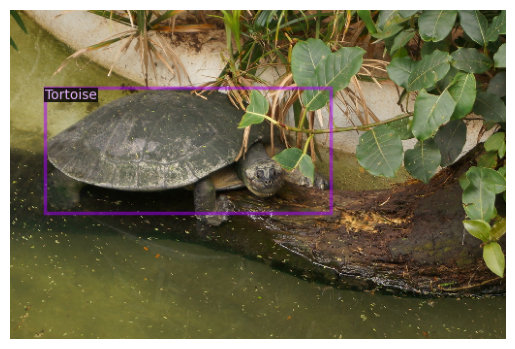

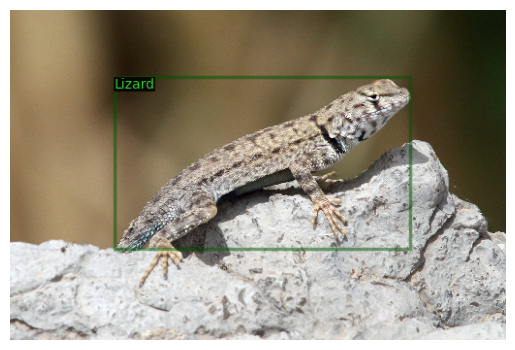

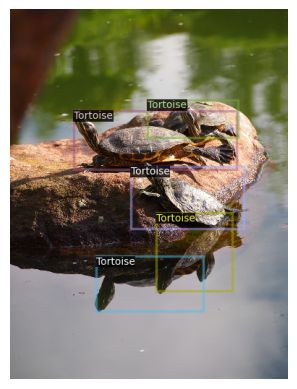

In [4]:
# lets see some samples of the dataset
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/open-images-v7/train/")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=turnliz_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

# Train our model

There are plenty of models available, you can go to <br>
detectron2/detectron2/model_zoo/configs/ <br>
to choose a model <br>
name "my_yaml" as the location of the yaml  <br>
Check <br>
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md <br>
for details of models

In [5]:
# e.g.
my_yaml = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

In [6]:
# clear metrics.json for new training
import os
metrics_file = "output/metrics.json"
if os.path.exists(metrics_file):
    os.remove(metrics_file)

In [7]:
#from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
# check current config before adjustment
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    F

# Augmentations
We can use the package built-in augmentation policy or add Albumentations function to the process <br>
Choose either one but we suggest stick to built-in augmentation if it satistys your needs <br>
Try gradually intensify augmentation <br>
Here we first introduce built-in augmentation <br>
You can know more about it at https://detectron2.readthedocs.io/en/latest/tutorials/augmentation.html#basic-usage <br>

In [8]:
# check current augmentation policy before adjustment
from detectron2.data import DatasetMapper
mapper = DatasetMapper(cfg, is_train=True)
print(mapper.augmentations)

AugmentationList[ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


In [9]:
# Replace the list with our self defined one
from detectron2.data import transforms as T

transform_list = [
        T.ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), # copy
        T.RandomFlip(),  # copy
        T.RandomBrightness(0.9, 1.1), # you define, divert from 1
        T.RandomContrast(0.9, 1.1), # you define, divert from 1
        T.RandomSaturation(0.9, 1.1), # you define, divert from 1
        T.RandomRotation(angle=[-2.5, 2.5]), # you define, divert from 0 upto 90, but dont make it large
        #T.RandomLighting(0.1), # you define, more the stronger
    ]

# Append it to the end (or use insert to place it earlier)
mapper.augmentations = T.AugmentationList(transform_list)

We then introduce albumentations augmentation <br>
you can know more about it at https://github.com/albumentations-team/albumentations

In [10]:
# check current augmentation policy before adjustment
from detectron2.data import DatasetMapper
mapper = DatasetMapper(cfg, is_train=True)
print(mapper.albumentations)
# its none by default

[]


In [11]:
import albumentations as A
# add yours
transform_list = [
        A.Affine(scale=(0.98, 1.02), translate_percent=(-0.01,0.01), rotate=(-2, 2), shear=(-2, 2), p=1.0),
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1.0),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1.0),
        ]
mapper.albumentations = transform_list

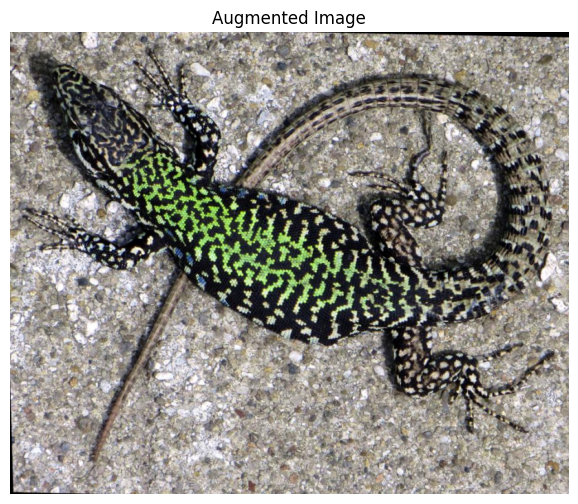

In [12]:
# See what augmentation do, you may rerun the script, that get different result
sample = dataset_dicts[0]  # Take one sample
# Apply the mapper (this runs the augmentation pipeline)
augmented = mapper(sample)
# The image is in CHW format and BGR
img = augmented["image"].permute(1, 2, 0).numpy()  # Convert to HWC
img = img[:, :, ::-1]  # BGR to RGB
# Plot with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("Augmented Image")
plt.axis("off")
plt.show()

In [13]:
from tools.train_net import Trainer
from detectron2.data import build_detection_train_loader
class CustomTrainer(Trainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

# start training !!
you may revise the configs to meet your custom needs

In [14]:
cfg.DATASETS.TRAIN = ('turnliz_train',)
cfg.DATASETS.TEST = ('turnliz_validation',) 
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(my_yaml)
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR' # This is our preferred scheduler
cfg.SOLVER.IMS_PER_BATCH = 4  # batch size
cfg.SOLVER.BASE_LR = cfg.SOLVER.BASE_LR/8  # pick a good LR, if you have no idea, start with the default divided by 8
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []         # decay learning rate (none here)
cfg.SOLVER.WARMUP_ITERS = 100 # warmup iteration, a small fraction of max iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 2 classes (we have tortoise and lizard)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# Validation settings
cfg.TEST.EVAL_PERIOD = 100  # Evaluate every 100 iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 100  # Save checkpoint every 100 iterations

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/01 15:04:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:02, 101MB/s]                                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters o

[07/01 15:04:50 d2.engine.train_loop]: Starting training from iteration 0


/home/z890/.conda/envs/faster_d2/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/01 15:04:54 d2.utils.events]:  eta: 0:02:26  iter: 19  total_loss: 1.381  loss_cls: 0.7203  loss_box_reg: 0.4875  loss_rpn_cls: 0.002474  loss_rpn_loc: 0.01042    time: 0.1474  last_time: 0.1504  data_time: 0.0153  last_data_time: 0.0048   lr: 0.0004654  max_mem: 6689M
[07/01 15:04:56 d2.utils.events]:  eta: 0:02:17  iter: 39  total_loss: 0.8529  loss_cls: 0.3204  loss_box_reg: 0.5068  loss_rpn_cls: 0.007428  loss_rpn_loc: 0.009722    time: 0.1431  last_time: 0.1488  data_time: 0.0052  last_data_time: 0.0059   lr: 0.00095267  max_mem: 6692M
[07/01 15:04:59 d2.utils.events]:  eta: 0:02:10  iter: 59  total_loss: 0.7315  loss_cls: 0.233  loss_box_reg: 0.4818  loss_rpn_cls: 0.003764  loss_rpn_loc: 0.01129    time: 0.1405  last_time: 0.1108  data_time: 0.0050  last_data_time: 0.0046   lr: 0.0014399  max_mem: 6692M
[07/01 15:05:02 d2.utils.events]:  eta: 0:02:05  iter: 79  total_loss: 0.7072  loss_cls: 0.2439  loss_box_reg: 0.433  loss_rpn_cls: 0.006452  loss_rpn_loc: 0.01329    time: 0.

In [15]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# plot learning curve

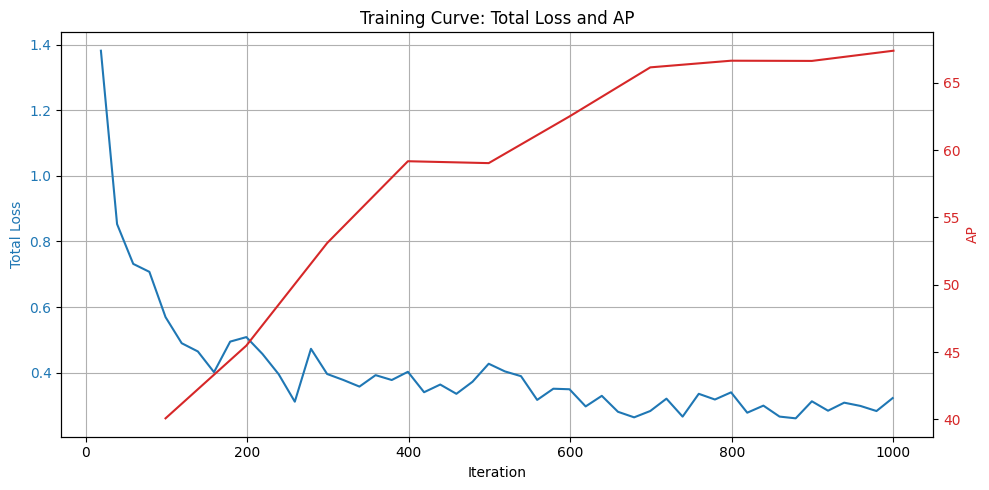

In [16]:
import matplotlib.pyplot as plt
import json

def plot_training_curve(json_path):
    # Load the metrics
    with open(json_path, 'r') as f:
        lines = f.readlines()
        metrics = [json.loads(line) for line in lines if 'total_loss' in line]
        metrics2 = [json.loads(line) for line in lines if 'bbox/AP' in line]

    iterations = [x["iteration"] for x in metrics]
    losses = [x["total_loss"] for x in metrics]
    iterations2 = [x["iteration"] for x in metrics2]
    ap = [x["bbox/AP"] for x in metrics2]

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot loss on the left y-axis
    color = 'tab:blue'
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Total Loss", color=color)
    ax1.plot(iterations, losses, color=color, label="Total Loss")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create second y-axis for AP50
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("AP", color=color)
    ax2.plot(iterations2, ap, color=color, label="AP")
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title("Training Curve: Total Loss and AP")
    fig.tight_layout()
    plt.show()

    
plot_training_curve("output/metrics.json")

# Read the training log
Every few iteration, the log prints current training status incluing Loss and learning rate(LR). <br>
and then current performance in COCO metrics. <br>

In ideal scenario, training loss decreases and accuracy increases gradually throughout the training. <br> 
When it comes to the end of training, training loss would still decreases slightly, while accuracy stops improving, and it should be already satisfactory. <br>
 <br>
If training loss decreases and accuracy increases slowly, you may increase learning rate (eg double it) <br>
If both training loss and accuracy flutuate violently, you may decrease learning rate (eg half it) <br>
If accuracy is still improving at the end of training, you may increase number of epoch <br>
If training loss decreases while accuracy stagnates or worsens before getting satisfactory accuracy, you should add more samples or implement stronger augmentation, and ensure the two datasets are alike <br>
If both training loss and accuracy stagnates, and the accuracy is not satisfactory, you should consider choosing a more advanced or larger model <br>

# Inference
Here we inference on images <br>

In [17]:
# see how the trained model performs on validation images
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
#print(f'Config:\n{cfg}')

[07/01 15:07:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


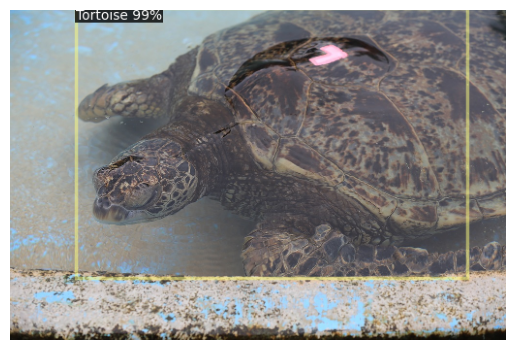

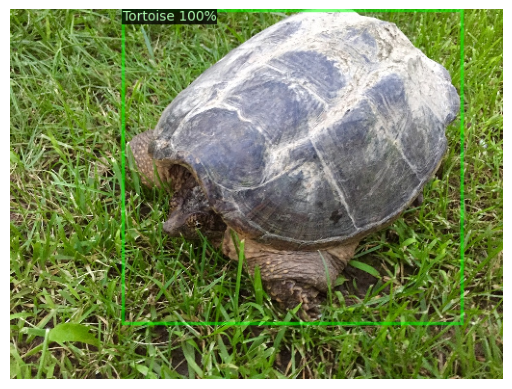

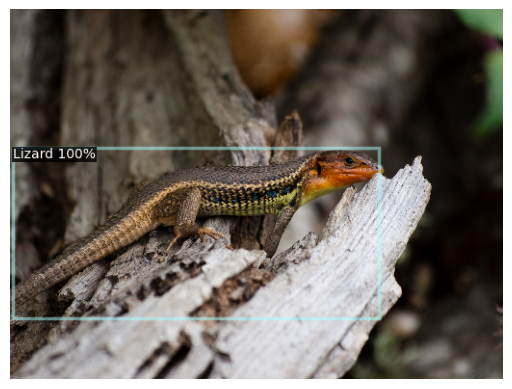

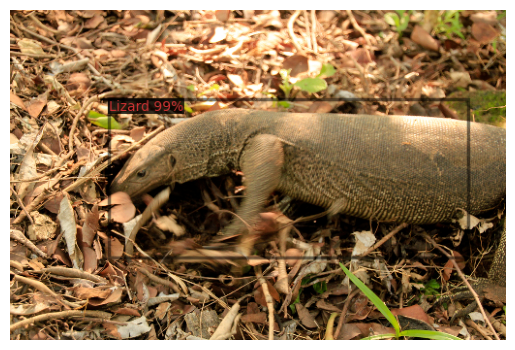

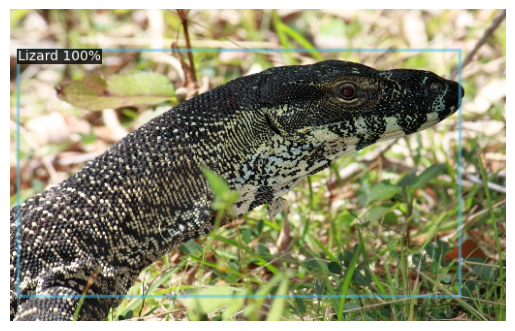

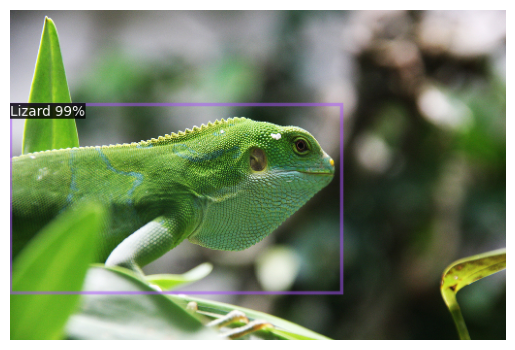

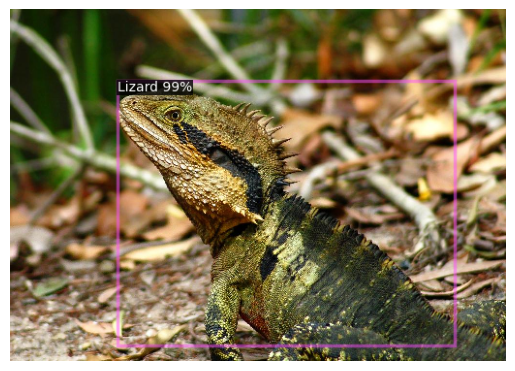

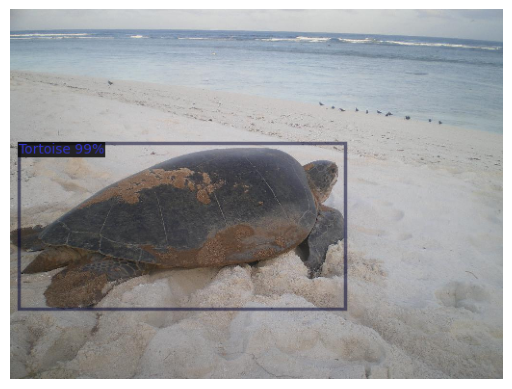

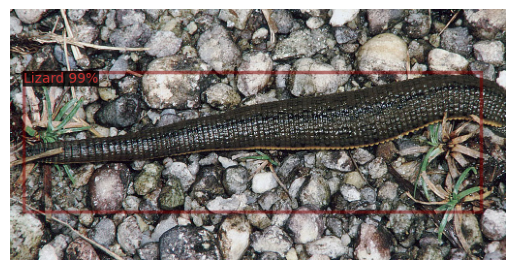

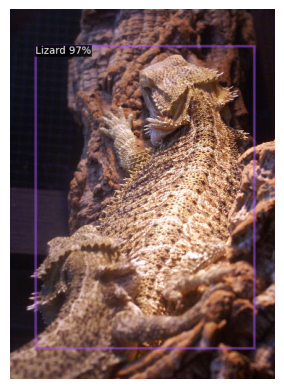

In [18]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/open-images-v7/validation/")
turnliz_metadataval = MetadataCatalog.get("turnliz_validation")
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=turnliz_metadataval,
                   scale=0.5,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

# Export the model to onnx

In [19]:
import torch
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.export import TracingAdapter
from detectron2.data import build_detection_test_loader
from detectron2 import model_zoo
import os
import onnx 
import cv2

# Step 1: Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.DEVICE = "cuda"
# revise to match our number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


# Step 2: Create Pytorch Model
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

# Step 3: Trace the model with appropriate inputs
#im can be any image of your training/validation dataset 
im = cv2.imread("dataset/open-images-v7/validation/0ebb1151fd4e8fe4.jpg")
im_torch = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
inputs = [{"image": im_torch}]

traceable_model = TracingAdapter(model, inputs, None)

# Step 4: Export to ONNX with appropriate dynamic axes
torch.onnx.export(traceable_model, (im_torch,), 
                  "model.onnx", 
                  opset_version=16,
                  input_names = ['image'],
                  output_names = ['instances'],
                  dynamic_axes={'image' : {1 : 'height', 2: 'width'},
                                'instances' : {0 : 'batch_size'}}
                                )

[07/01 15:07:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/z890/Downloads/ml_develop_sample/carasml/detection/d2_FasterRCNN/detectron2/detectron2/structures/image_list.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/home/z890/Downloads/ml_develop_sample/carasml/detection/d2_FasterRCNN/detectron2/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/home/z890/Downloads/ml_develop_sample/carasml/detection/d2_FasterRCNN/detectron2/detectron2/structures/boxes.py:155: TracerWarning: Converting a te

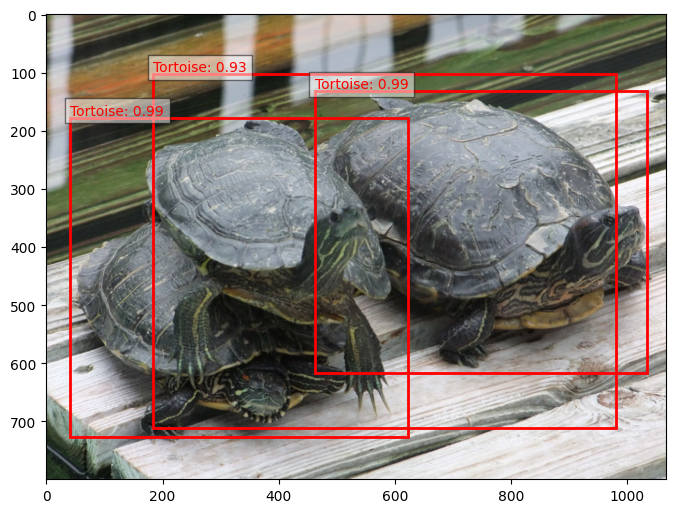

In [20]:
# try our onnx
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
from detectron2.data.transforms import ResizeTransform

# resize the image, min_size=800, max_size=1333 is the default setting
def resize(im, min_size=800, max_size=1333):
    h, w = im.shape[:2]
    scale = min_size / min(h, w)
    if max(h, w) * scale > max_size:
        scale = max_size / max(h, w)
    new_w = int(w * scale + 0.5)
    new_h = int(h * scale + 0.5)
    return cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# Create an ONNX Runtime session
session = ort.InferenceSession("model.onnx")

im = cv2.imread("dataset/open-images-v7/validation/8201cac18b3e815f.jpg")
im = resize(im)

# Run inference
outputs = session.run(None, {"image": im.astype("float32").transpose(2, 0, 1)})
boxes, classes, scores, size = outputs

# Set score threshold
minimum_score = 0.7

# Filter valid detections
valid_detections = scores > minimum_score
valid_boxes = boxes[valid_detections]
valid_classes = classes[valid_detections]
valid_scores = scores[valid_detections]

# Plot image
plt.figure(figsize=(8, 8))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
ax = plt.gca()

class_name = ["Tortoise", "Lizard"]
# Draw bounding boxes with labels
for box, cls, score in zip(valid_boxes, valid_classes, valid_scores):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_name[cls]}: {score:.2f}", color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

plt.show()


# Assess performance for each class
To better understand how our model perform, we can plot precision recall curve and confusion matrix

In [21]:
#In case you want to evaluate specific checkpoints, you can run this script. Here we proceed base on the predictions of last checkpoint.
'''
# Step 1: Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000899.pth")
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01  # To plot the below chart we set 0.01, otherwise you can set desired threshold

# Step 2: Create Pytorch Model
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

# Step 3: Run Evaluation Function
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("turnliz_validation", ("bbox",), False, output_dir="./output/eval")
val_loader = build_detection_test_loader(cfg, "turnliz_validation")
print(inference_on_dataset(model, val_loader, evaluator)) 

import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()
'''

'\n# Step 1: Load the configuration and model\ncfg = get_cfg()\ncfg.merge_from_file(model_zoo.get_config_file(my_yaml))\ncfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000899.pth")\ncfg.MODEL.DEVICE = "cuda"\ncfg.MODEL.ROI_HEADS.NUM_CLASSES = 2\ncfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01  # To plot the below chart we set 0.01, otherwise you can set desired threshold\n\n# Step 2: Create Pytorch Model\nmodel = build_model(cfg)\nDetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)\nmodel.eval()\n\n# Step 3: Run Evaluation Function\nfrom detectron2.evaluation import COCOEvaluator, inference_on_dataset\nfrom detectron2.data import build_detection_test_loader\nevaluator = COCOEvaluator("turnliz_validation", ("bbox",), False, output_dir="./output/eval")\nval_loader = build_detection_test_loader(cfg, "turnliz_validation")\nprint(inference_on_dataset(model, val_loader, evaluator)) \n\nimport torch\n#after training/testing, clear cache\ntorch.cuda.empty_cache()\ntorch.cuda.synchroniz

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


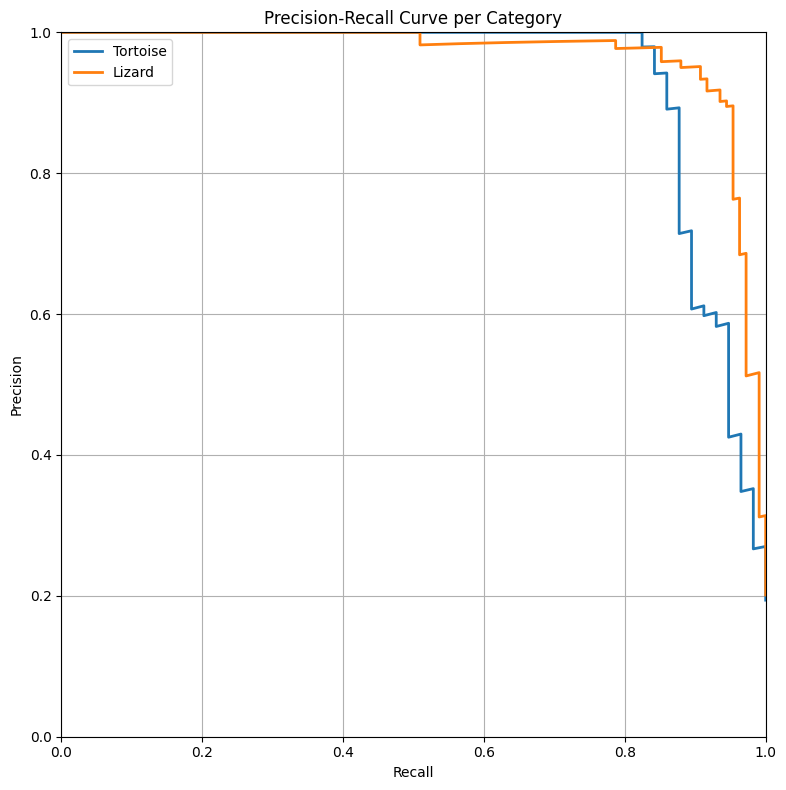

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

#When training and validation executed previously, it saves the ground turth annotation json here
truth_json = 'output/inference/turnliz_validation_coco_format.json' 
#When training and validation executed previously, it saves the prediction annotation json here
pred_json = 'output/inference/coco_instances_results.json' 
# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    cat_id = cat_id
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']

        best_iou = iou_threshold
        best_gt_id = None
        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_id = gt['id']
        used.add(best_gt_id)
        y_true.append(1 if best_gt_id is not None else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall
    }

# Plotting Precision-Recall curves
plt.figure(figsize=(10, 8))
for cat_id, data in class_curves.items():
    plt.plot(data['recall'], data['precision'], label=cat_id_to_name[cat_id], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Category')
plt.grid(True)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('precision_recall_curves.png', bbox_inches='tight', dpi=300)
plt.show()

# The more area under the curve, the better the model. 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


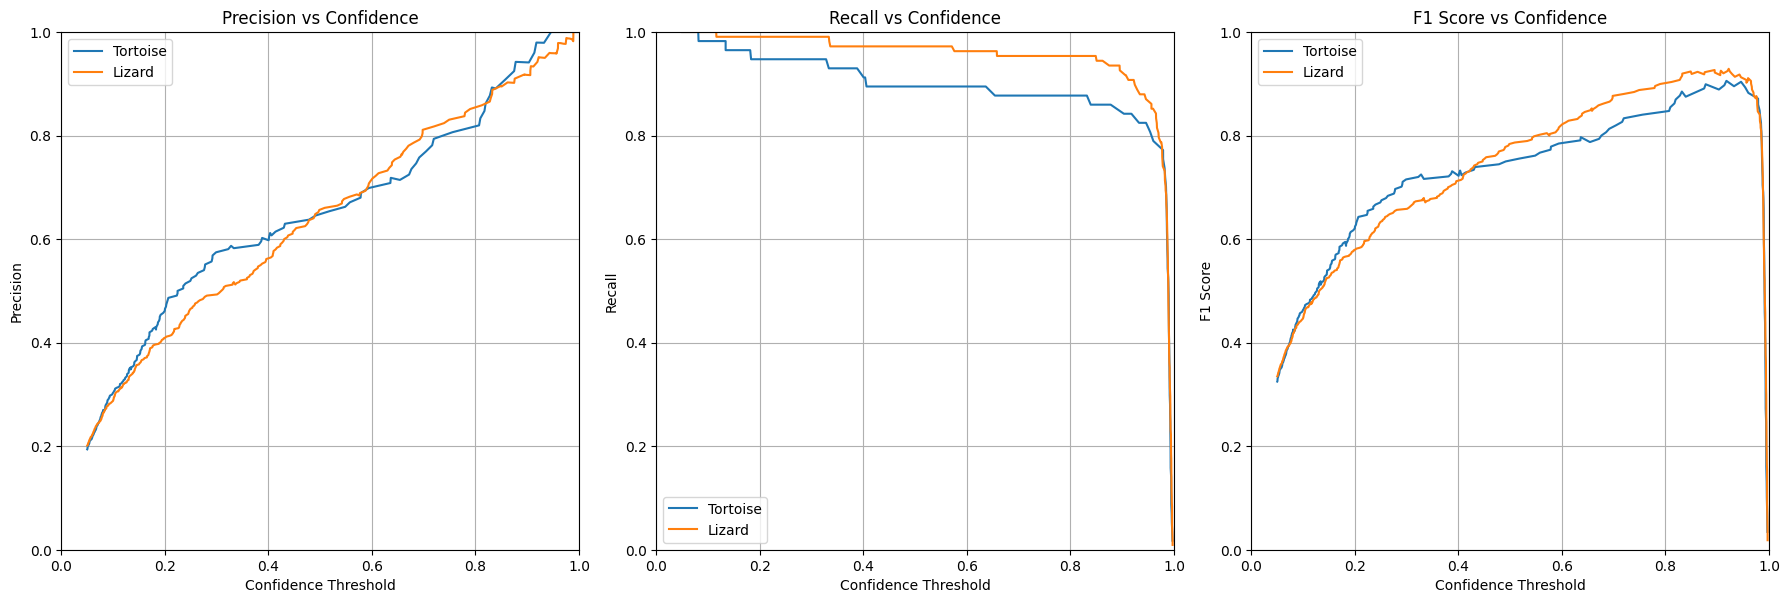

In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Load annotations and predictions
truth_json = 'output/inference/turnliz_validation_coco_format.json'
pred_json = 'output/inference/coco_instances_results.json'

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']

        best_iou = iou_threshold
        best_gt_id = None
        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_id = gt['id']
        used.add(best_gt_id)
        y_true.append(1 if best_gt_id is not None else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }

# Plotting
plt.figure(figsize=(18, 6))

# 1. Precision-Confidence
plt.subplot(1, 3, 1)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['precision'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 2. Recall-Confidence
plt.subplot(1, 3, 2)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['recall'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 3. NEW: F1-Confidence
plt.subplot(1, 3, 3)
for cat_id, data in class_curves.items():
    # Calculate F1 scores
    precision = data['precision'][:-1]
    recall = data['recall'][:-1]
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    plt.plot(data['thresholds'], f1_scores, 
             label=cat_id_to_name[cat_id])

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
#plt.savefig('precision_recall_f1_confidence.png', bbox_inches='tight', dpi=300)
plt.show()

# you can choose a confidence threshold that has highest F1 Score when inference.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


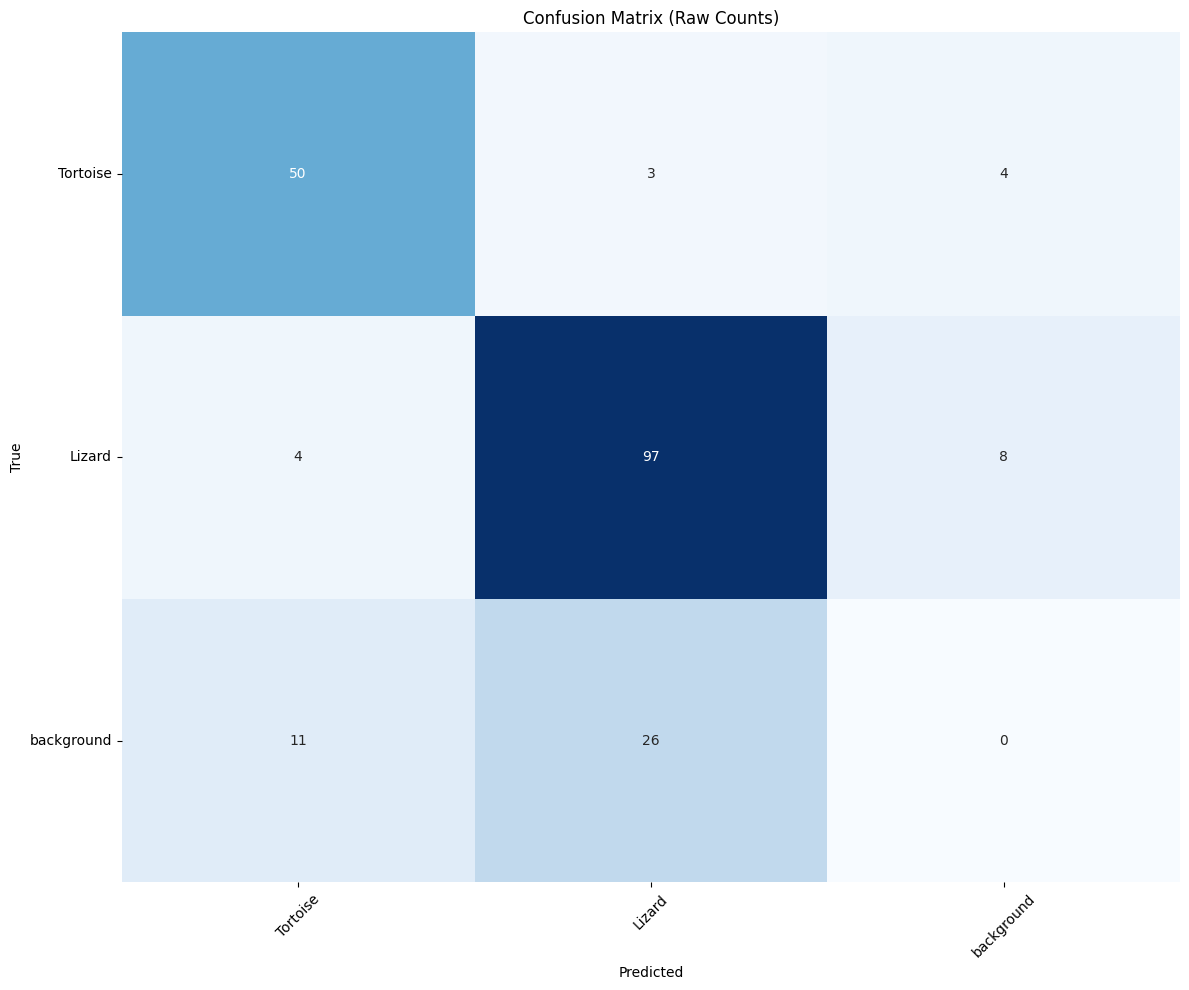

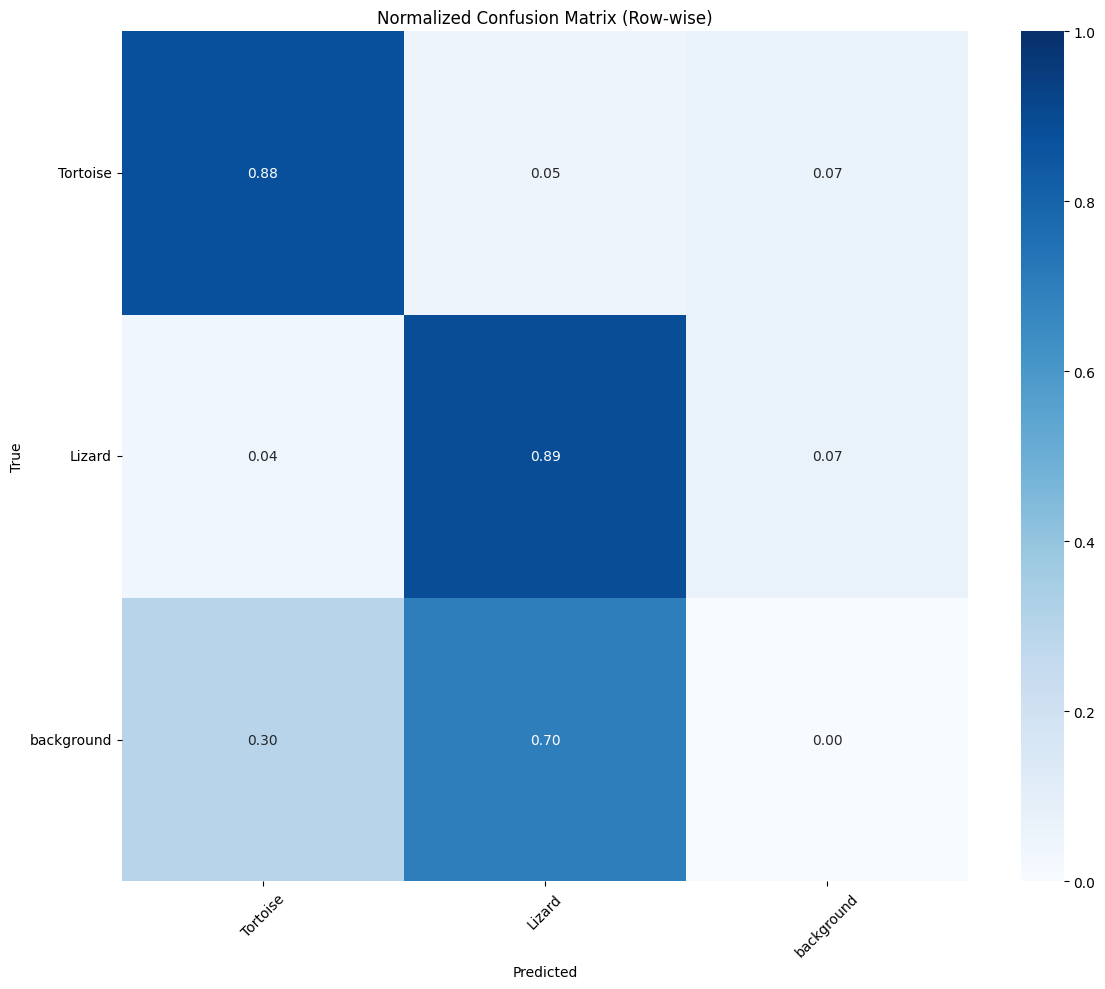

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools import mask as maskUtils
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Load ground truth and predictions
truth_json = 'output/inference/turnliz_validation_coco_format.json'
pred_json = 'output/inference/coco_instances_results.json'

# Load COCO API for ground truth
coco_gt = COCO(truth_json)

# Load the original predictions
with open(pred_json) as f:
    pred_data = json.load(f)
    
# filter out low confidence
threshold = 0.7
filtered_data = [pred_data_t for pred_data_t in pred_data if pred_data_t['score']>=threshold]
coco_dt = coco_gt.loadRes(filtered_data)

class_names = [coco_gt.loadCats(ids)[0]['name'] for ids in coco_gt.getCatIds()]
num_classes = len(class_names)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

def compute_confusion_matrix(coco_gt, coco_dt, iou_thresh=0.65):
    """
    Compute confusion matrix with IoU matching
    Returns: (raw_confusion_matrix, normalized_confusion_matrix)
    """
    num_classes = len(coco_gt.getCatIds())
    cm = np.zeros((num_classes+1, num_classes+1), dtype=int)  # +1 for background/FP
    
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))

        # Track which GT boxes have been matched
        matched_gt = [False] * len(gt_anns)
        
        # Process detections sorted by confidence (highest first)
        dt_anns = sorted(dt_anns, key=lambda x: -x['score'])
        
        for dt in dt_anns:
            best_iou = iou_thresh
            best_idx = -1
            
            # Find best matching GT
            for i, gt in enumerate(gt_anns):
                if not matched_gt[i]:
                    iou = compute_iou(dt['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = i
            
            if best_idx >= 0:  # True positive (of at least there is object, despite of classes)
                matched_gt[best_idx] = True
                gt_class = gt_anns[best_idx]['category_id']  
                dt_class = dt['category_id']   
                cm[gt_class, dt_class] += 1
            else:  # False positive
                dt_class = dt['category_id'] 
                cm[-1, dt_class] += 1  # Last row is for FP
        
        # Any unmatched GT are false negatives
        for i, matched in enumerate(matched_gt):
            if not matched:
                gt_class = gt_anns[i]['category_id'] 
                cm[gt_class, -1] += 1  # Last column is for FN
    
    # Normalized version (row-wise)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
    
    return cm, cm_norm

# Compute matrices
cm_raw, cm_norm = compute_confusion_matrix(coco_gt, coco_dt)
class_names_with_bg = class_names + ['background']
# Plot raw confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_raw, annot=True, fmt='d', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_raw.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# The counts lie inside the top left to bottom right diagonal are the correct predictions
# The others are wrong predictions, where the x-axis is the predicted label and the y-axis is true label
# eg, the top right corner are the samples that are actually tortoise but misclassified as background